Device: cuda
Model loaded successfully
Sampled 2 images:
 • ILSVRC2012_val_00013684.JPEG
 • ILSVRC2012_val_00004001.JPEG
Fragment-level accuracy : 61.11%
Puzzle-level accuracy   : 50.00%

Image 1:
  Ground Truth Order: [4, 2, 5, 1, 8, 3, 0, 7, 6]
  Predicted Order   : [4, 2, 5, 1, 8, 3, 0, 7, 6]

Image 2:
  Ground Truth Order: [1, 8, 4, 3, 2, 7, 6, 0, 5]
  Predicted Order   : [4, 4, 4, 3, 4, 4, 4, 1, 4]


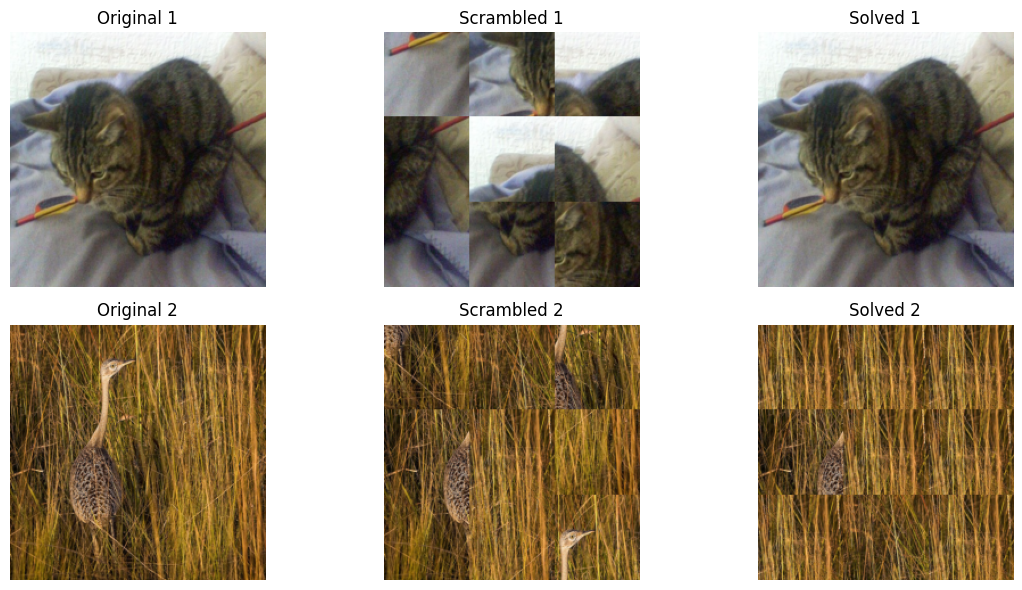


Visualization complete!


In [2]:
import torch, random, pathlib
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from puzzle_fcvit import FCViT

# ────────────────────────────── CONFIG ────────────────────────────── #
CKPT_PATH   = "/cluster/home/muhamhz/fcvit-mt-ntnu/checkpoint/FCViT_base_3x3_ep100_lr3e-05_b64.pt"
IMG_ROOT    = "/cluster/home/muhamhz/data/imagenet/val"
N_IMAGES    = 2                      # visualize 2 images
BACKBONE    = "vit_base_patch16_224"
PUZZLE_SIZE = 225
FRAG_SIZE   = 75
NUM_FRAG    = 9

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------- load model ----------
ckpt = torch.load(CKPT_PATH, map_location="cpu", weights_only=True)
state = {k.replace("module.", "", 1): v for k, v in ckpt["model"].items()}

model = FCViT(backbone=BACKBONE, num_fragment=NUM_FRAG, size_fragment=FRAG_SIZE).to(device)
model.load_state_dict(state, strict=True)
model.eval()
model.augment_fragment = transforms.Resize((FRAG_SIZE, FRAG_SIZE), antialias=True)
print("Model loaded successfully")

# ---------- sample images ----------
img_paths = random.sample(list(pathlib.Path(IMG_ROOT).rglob("*.JPEG")), N_IMAGES)
print(f"Sampled {N_IMAGES} images:")
for p in img_paths:
    print(f" • {p.name}")

tfs = transforms.Compose([
    transforms.Resize((PUZZLE_SIZE, PUZZLE_SIZE), antialias=True),
    transforms.ToTensor()
])
imgs_gpu = torch.stack([tfs(Image.open(p).convert("RGB")) for p in img_paths]).to(device)

# ---------- inference ----------
with torch.no_grad():
    pred_gpu, tgt_gpu = model(imgs_gpu)

pred_ = model.mapping(pred_gpu.clone())
tgt_  = model.mapping(tgt_gpu.clone())

acc_frag = (pred_ == tgt_).all(dim=2).float().mean().item() * 100
acc_puzz = (pred_ == tgt_).all(dim=2).all(dim=1).float().mean().item() * 100
print(f"Fragment-level accuracy : {acc_frag:.2f}%")
print(f"Puzzle-level accuracy   : {acc_puzz:.2f}%")

# ---------- prepare for plotting ----------
imgs_cpu  = imgs_gpu.cpu()
pred_cpu  = pred_.cpu()
tgt_cpu   = tgt_.cpu()
map_coord = model.map_coord.cpu()

def unshuffle(tensor, order):
    C, H, W = tensor.shape
    p = FRAG_SIZE
    pieces = [tensor[:, i:i+p, j:j+p] for i in range(0, H, p) for j in range(0, W, p)]
    grid   = [pieces[idx] for idx in order]
    rows   = [torch.cat(grid[i:i+3], dim=2) for i in range(0, 9, 3)]
    return torch.cat(rows, dim=1)

# ---------- visualize inline ----------
plt.figure(figsize=(12, 6))

for i, (img, ord_pred, ord_gt) in enumerate(zip(imgs_cpu, pred_cpu, tgt_cpu)):
    mask_pred = (ord_pred[:, None, :] == map_coord).all(-1).long()
    mask_gt   = (ord_gt  [:, None, :] == map_coord).all(-1).long()
    ord_pred_i = mask_pred.argmax(dim=1)
    ord_gt_i   = mask_gt.argmax(dim=1)

    print(f"\nImage {i+1}:")
    print(f"  Ground Truth Order: {ord_gt_i.tolist()}")
    print(f"  Predicted Order   : {ord_pred_i.tolist()}")
    
    # Original image
    plt.subplot(N_IMAGES, 3, 3*i+1)
    plt.imshow(unshuffle(img, ord_gt_i).permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Original {i+1}")

    # Scrambled image
    plt.subplot(N_IMAGES, 3, 3*i+2)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Scrambled {i+1}")

    # Solved puzzle
    plt.subplot(N_IMAGES, 3, 3*i+3)
    plt.imshow(unshuffle(img, ord_pred_i).permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Solved {i+1}")

plt.tight_layout()
plt.show()
print("\nVisualization complete!")

Device: cuda
Model loaded successfully
Sampled 2 images:
 • ILSVRC2012_val_00013686.JPEG
 • ILSVRC2012_val_00045302.JPEG
Fragment-level accuracy : 55.56%
Puzzle-level accuracy   : 50.00%

Image 1:
  Ground Truth Order: [7, 4, 6, 8, 3, 1, 2, 0, 5]
  Predicted Order   : [7, 4, 6, 8, 3, 1, 2, 0, 5]

Image 2:
  Ground Truth Order: [1, 2, 8, 6, 5, 0, 7, 4, 3]
  Predicted Order   : [4, 4, 4, 4, 4, 4, 4, 4, 4]


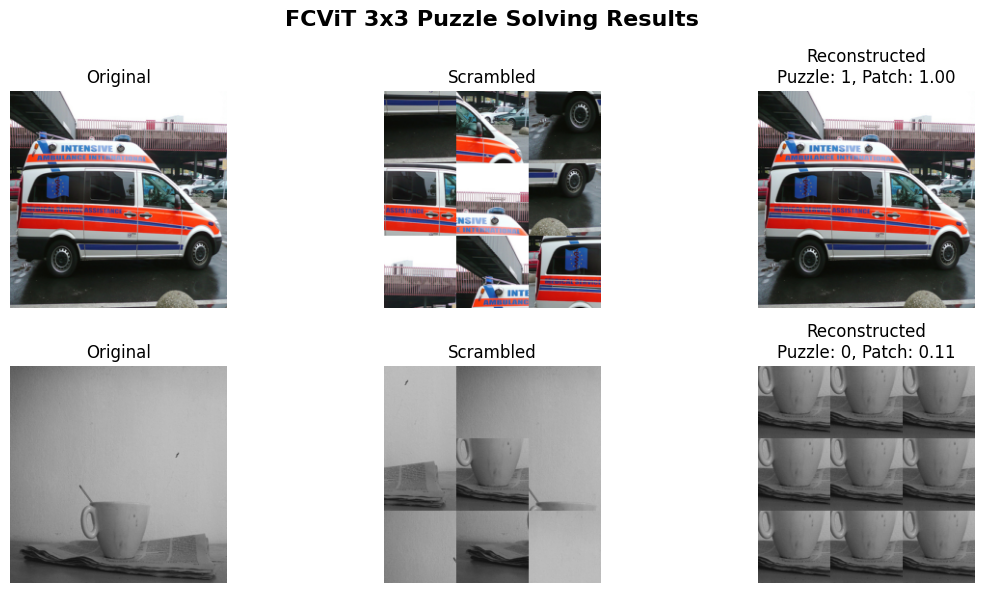


Visualization complete!


: 

In [ ]:
import torch, random, pathlib
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from puzzle_fcvit import FCViT

# ────────────────────────────── CONFIG ────────────────────────────── #
CKPT_PATH   = "/cluster/home/muhamhz/fcvit-mt-ntnu/checkpoint/FCViT_base_3x3_ep100_lr3e-05_b64.pt"
IMG_ROOT    = "/cluster/home/muhamhz/data/imagenet/val"
N_IMAGES    = 2                      # visualize 2 images
BACKBONE    = "vit_base_patch16_224"
PUZZLE_SIZE = 225
FRAG_SIZE   = 75
NUM_FRAG    = 9

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------- load model ----------
ckpt = torch.load(CKPT_PATH, map_location="cpu", weights_only=True)
state = {k.replace("module.", "", 1): v for k, v in ckpt["model"].items()}

model = FCViT(backbone=BACKBONE, num_fragment=NUM_FRAG, size_fragment=FRAG_SIZE).to(device)
model.load_state_dict(state, strict=True)
model.eval()
model.augment_fragment = transforms.Resize((FRAG_SIZE, FRAG_SIZE), antialias=True)
print("Model loaded successfully")

# ---------- sample images ----------
img_paths = random.sample(list(pathlib.Path(IMG_ROOT).rglob("*.JPEG")), N_IMAGES)
print(f"Sampled {N_IMAGES} images:")
for p in img_paths:
    print(f" • {p.name}")

tfs = transforms.Compose([
    transforms.Resize((PUZZLE_SIZE, PUZZLE_SIZE), antialias=True),
    transforms.ToTensor()
])
imgs_gpu = torch.stack([tfs(Image.open(p).convert("RGB")) for p in img_paths]).to(device)

# ---------- inference ----------
with torch.no_grad():
    pred_gpu, tgt_gpu = model(imgs_gpu)

pred_ = model.mapping(pred_gpu.clone())
tgt_  = model.mapping(tgt_gpu.clone())

acc_frag = (pred_ == tgt_).all(dim=2).float().mean().item() * 100
acc_puzz = (pred_ == tgt_).all(dim=2).all(dim=1).float().mean().item() * 100
print(f"Fragment-level accuracy : {acc_frag:.2f}%")
print(f"Puzzle-level accuracy   : {acc_puzz:.2f}%")

# ---------- prepare for plotting ----------
imgs_cpu  = imgs_gpu.cpu()
pred_cpu  = pred_.cpu()
tgt_cpu   = tgt_.cpu()
map_coord = model.map_coord.cpu()

def unshuffle(tensor, order):
    C, H, W = tensor.shape
    p = FRAG_SIZE
    pieces = [tensor[:, i:i+p, j:j+p] for i in range(0, H, p) for j in range(0, W, p)]
    grid   = [pieces[idx] for idx in order]
    rows   = [torch.cat(grid[i:i+3], dim=2) for i in range(0, 9, 3)]
    return torch.cat(rows, dim=1)

# ---------- visualize inline ----------
plt.figure(figsize=(12, 6))

for i, (img, ord_pred, ord_gt) in enumerate(zip(imgs_cpu, pred_cpu, tgt_cpu)):
    mask_pred = (ord_pred[:, None, :] == map_coord).all(-1).long()
    mask_gt   = (ord_gt  [:, None, :] == map_coord).all(-1).long()
    ord_pred_i = mask_pred.argmax(dim=1)
    ord_gt_i   = mask_gt.argmax(dim=1)

    # Calculate individual image accuracy
    puzzle_correct = (ord_pred_i == ord_gt_i).all().int().item()
    patch_accuracy = (ord_pred_i == ord_gt_i).float().mean().item()

    print(f"\nImage {i+1}:")
    print(f"  Ground Truth Order: {ord_gt_i.tolist()}")
    print(f"  Predicted Order   : {ord_pred_i.tolist()}")
    
    # Original image
    plt.subplot(N_IMAGES, 3, 3*i+1)
    plt.imshow(unshuffle(img, ord_gt_i).permute(1, 2, 0))
    plt.axis('off')
    plt.title("Original")

    # Scrambled image
    plt.subplot(N_IMAGES, 3, 3*i+2)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Scrambled")

    # Solved puzzle
    plt.subplot(N_IMAGES, 3, 3*i+3)
    plt.imshow(unshuffle(img, ord_pred_i).permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Reconstructed\nPuzzle: {puzzle_correct}, Patch: {patch_accuracy:.2f}")

plt.suptitle("FCViT 3x3 Puzzle Solving Results", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("\nVisualization complete!")